# Определение перспективного тарифа для телеком-компании

Для исследования тарифов используются данные оператора сотовой связи «Мегалайн», которые содержат информацию о 500 пользователях за 2018 год. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

Цель исследования: определить наиболее выгодный тариф для оператора сотовой связи.

**Описание данных**

Таблица users (информация о пользователях):

* user_id — уникальный идентификатор пользователя;
* first_name — имя пользователя;
* last_name — фамилия пользователя;
* age — возраст пользователя (годы);
* reg_date — дата подключения тарифа (день, месяц, год);
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
* city — город проживания пользователя;
* tariff — название тарифного плана.

Таблица calls (информация о звонках):

* id — уникальный номер звонка;
* call_date — дата звонка;
* duration — длительность звонка в минутах;
* user_id — идентификатор пользователя, сделавшего звонок.

Таблица messages (информация о сообщениях):

* id — уникальный номер сообщения;
* message_date — дата сообщения;
* user_id — идентификатор пользователя, отправившего сообщение.

Таблица internet (информация об интернет-сессиях):

* id — уникальный номер сессии;
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
* session_date — дата интернет-сессии;
* user_id — идентификатор пользователя.

Таблица tariffs (информация о тарифах):

* tariff_name — название тарифа;
* rub_monthly_fee — ежемесячная абонентская плата в рублях;
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
* messages_included — количество сообщений в месяц, включённых в абонентскую плату;
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

## План работы

1. [Изучение данных](#1)

2. [Предобработка данных](#2)

  2.1 [Замена типа данных](#2.1)

  2.2 [Проверка и преобразование таблиц](#2.2)

  2.3 [Объединение таблиц](#2.3)

3. [Исследовательский анализ данных](#3)

4. [Проверка гипотез](#4)

  4.1  [Сравнение средней выручки по тарифам](#4.1)

  4.2  [Сравнение средней выручки пользователей из Москвы и регионов](#4.2)

5. [Общие выводы](#5)

<a name="1"><h2>1 Изучение данных</h2></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from scipy import stats as st

Прочитаем файлы и сохраним в переменных calls, internet, messages и users и tariffs:

In [2]:
calls = pd.read_csv('/content/calls.csv')
internet = pd.read_csv('/content/internet.csv')
messages = pd.read_csv('/content/messages.csv')
users = pd.read_csv('/content/users.csv')
tariffs = pd.read_csv('/content/tariffs.csv')

Выведем на экран первые строки таблицы 'calls' и просмотрим общую информацию:

In [3]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Таблица 'calls' содержит информацию о звонках, всего 202607 строк и 4 столбца, пропусков нет.

Просмотрим данные таблицы 'internet':

In [5]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Таблица 'internet' содержит информацию об интернет-сессиях, всего 149396 строк и 5 столбцов, пропусков нет.

Просмотрим данные таблицы 'messages':

In [7]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Таблица 'messages' содержит информацию о сообщениях, всего 123036 строк и 3 столбца, пропусков нет.

Просмотрим данные таблицы users:

In [9]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице 'users' 8 столбцов. В каждой строке таблицы данные, которые содержат информацию о пользователях. Всего 500 записей.

Просмотрим данные таблицы 'tariffs':

In [11]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица 'tariffs' содержит информацию о тарифах, всего 2 строки и 8 столбцов.

<div style="border: solid green 2px; padding: 20px">
    
**Выводы**

* В таблицах 'users', 'calls', 'internet' и 'messages' содержатся столбцы с датой, которые имеют тип object, переведём их в формат даты.
* Пропуски есть только в таблице 'users' в столбце 'churn_date', которые означают, что тариф еще действует, поэтому обрабатывать такие строки не нужно. 
* В таблице 'internet' столбец 'Unnamed: 0' дублирует индексы, поэтому его можно удалить.
* Для дальнейшего анализа удобнее объединить таблицы, преварительно подготовив сводные таблицы для 'calls', 'internet' и 'messages', в которых будет рассчитано для каждого пользователя сколько всего минут, сообщений и трафика за месяц было израсходовано.

<a name="2"><h2>2 Предобработка данных</h2></a>

<a name="2.1"><h3>2.1 Замена типа данных</h3></a>

Создадим функцию для замены типа на формат даты:

In [13]:
def type_data(table, column):
    table[column] = pd.to_datetime(table[column], format='%Y-%m-%d')

Применим функцию к таблицам:

In [14]:
type_data(users,'reg_date')
type_data(calls,'call_date')
type_data(internet,'session_date')
type_data(messages,'message_date')

<a name="2.2"><h3>2.2 Проверка и преобразование таблиц</h3></a>

Проверим в таблицах наличие возможных дубликатов, добавим столбцы с месяцем для дальнейшей оценки данных по месяцам и создадим сводные таблицы.

**Таблица 'calls'**

In [15]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Проверим на наличие явных дубликатов:

In [16]:
calls.duplicated().sum()

0

Дубликатов нет.

Так как каждый звонок округляется отдельно, то перед тем как создавать сводную таблицу с подсчетом итоговых минут за месяц, округлим минуты в столбце 'duration':

In [17]:
calls['duration'] = calls['duration'].apply(np.ceil)

Добавим столбец с месяцем:

In [18]:
calls['month'] = calls['call_date'].dt.month

Создадим сводную таблицу 'calls_pivot', которая будет содержать общее количество звонков и минут за каждый месяц:

In [19]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count','sum'])
calls_pivot.columns = ['total_calls','total_minutes']
calls_pivot.reset_index(inplace=True)
calls_pivot.head()

,user_id,month,total_calls,total_minutes
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


**Таблица 'internet'**

In [20]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Проверим таблицу 'internet' на наличие явных дубликатов:

In [21]:
internet.duplicated().sum()

0

Дубликатов нет.

Удалим столбец 'Unnamed: 0':

In [22]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

Добавим столбец с месяцем:

In [23]:
internet['month'] = internet['session_date'].dt.month

Создадим сводную таблицу 'internet_pivot', содержащую итоговое значение интернет-трафика по месяцам:

In [24]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_pivot.columns = ['total_gb']
internet_pivot.reset_index(inplace=True)
internet_pivot.head()

,user_id,month,total_gb
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Так как оператор округляет общую сумму мегабайтов за месяц до гигабайтов в большую сторону, то обновим столбец 'total_gb':

In [25]:
internet_pivot['total_gb'] = internet_pivot['total_gb'] / 1024
internet_pivot['total_gb'] = internet_pivot['total_gb'].apply(np.ceil)

Проверим результат:

In [26]:
internet_pivot.head()

,user_id,month,total_gb
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


**Таблица 'messages'**

In [27]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Добавим в таблицу 'messages' столбец с месяцем:

In [28]:
messages['month'] = messages['message_date'].dt.month

Создаём сводную таблицу 'messages_pivot' с общим количеством сообщений за месяц:

In [29]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_pivot.columns = ['total_messages']
messages_pivot.reset_index(inplace=True)
messages_pivot.head()

,user_id,month,total_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Таблица 'users'**

In [30]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Проверим таблицу 'users' на наличие дубликатов:

In [31]:
users.duplicated().sum()

0

Явных дубликатов нет. Проверим столбцы 'city' и 'tariff' на наличие неявных дубликатов:

In [32]:
users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

Записей немного, видно что названия записаны в одном стиле и дубикатов нет, поэтому в нижний регистр можно не переводить.

Посмотрим уникальные названия в столбце 'tariff':

In [33]:
users['tariff'].sort_values().unique()

array(['smart', 'ultra'], dtype=object)

Дубликатов тоже нет.

Удалим из таблицы столбцы, которые не понадобятся для анализа:

In [34]:
users.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date'], axis=1, inplace=True)

Проверим таблицу:

In [35]:
users.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


<div style="border: solid green 2px; padding: 20px">
    
**Выводы**
    
* В результате проверки таблиц дубликатов обнаружено не было.
* Созданы три сводные таблицы с общим количеством израсходованных сообщений, минут разговоров и интернет-трафика за месяц для каждого пользователя.
* В таблице 'users' удалены ненужные для дальнейшего исследования столбцы 'age', 'churn_date', 'first_name', 'last_name' и 'reg_date'.

<a name="2.3"><h3>2.3 Объединение таблиц</h3></a>

Создадим общую таблицу, объединив сводные таблицы 'calls_pivot', 'internet_pivot', 'messages_pivot' и таблицу 'users':

In [36]:
df = messages_pivot.merge(calls_pivot, on=['user_id','month'], how='outer')
df = df.merge(internet_pivot, on=['user_id','month'], how='outer')
df = df.merge(users, on='user_id', how='left')
df.head()

,user_id,month,total_messages,total_calls,total_minutes,total_gb,city,tariff
0,1000,5,22.0,22.0,159.0,3.0,Краснодар,ultra
1,1000,6,60.0,43.0,172.0,23.0,Краснодар,ultra
2,1000,7,75.0,47.0,340.0,14.0,Краснодар,ultra
3,1000,8,81.0,52.0,408.0,14.0,Краснодар,ultra
4,1000,9,57.0,58.0,466.0,15.0,Краснодар,ultra


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   total_messages  2717 non-null   float64
 3   total_calls     3174 non-null   float64
 4   total_minutes   3174 non-null   float64
 5   total_gb        3203 non-null   float64
 6   city            3214 non-null   object 
 7   tariff          3214 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


Всего в таблице 3214 строк. Пустые значения в столбцах 'total_messages', 'total_calls',	'total_minutes', 'total_gb' означают, что трафик не был израсходован пользователями, поэтому такие пропуски заменим на нули и поменяем в этих столбцах тип float на int, так как целочисленный формат более читабелен. Создадим для этого функцию:

In [38]:
def fill_gaps_type(columns):
    for column in columns:
        df[column] = df[column].fillna(0).astype('int')
    
fill_gaps_type(['total_messages', 'total_calls', 'total_minutes','total_gb'])

Проверим, что в таблице не осталось пропусков и тип данных:

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         3214 non-null   int64 
 1   month           3214 non-null   int64 
 2   total_messages  3214 non-null   int64 
 3   total_calls     3214 non-null   int64 
 4   total_minutes   3214 non-null   int64 
 5   total_gb        3214 non-null   int64 
 6   city            3214 non-null   object
 7   tariff          3214 non-null   object
dtypes: int64(6), object(2)
memory usage: 226.0+ KB


Теперь создадим функцию для расчета ежемесячной выручки с каждого пользователя. В функции проверяем тариф клиента и если количество израсходованных сообщений, минут или гигабайт превышает установленный лимит, то умножаем остаток на значение тарифного плана, затем считаем общую выручку за месяц, сложив возможный перерасход и абонентскую плату за месяц:

In [40]:
def revenue_calculation(row):
    tariff_inx = 0
    if row['tariff'] == 'ultra':
        tariff_inx = 1
    surcharge_for_messages = row['total_messages'] - tariffs.loc[tariff_inx, 'messages_included']
    if surcharge_for_messages > 0:
        surcharge_for_messages = surcharge_for_messages * tariffs.loc[tariff_inx, 'rub_per_message']
    else:
        surcharge_for_messages = 0

    surcharge_for_calls = row['total_minutes'] - tariffs.loc[tariff_inx, 'minutes_included']
    if surcharge_for_calls > 0:
        surcharge_for_calls = surcharge_for_calls * tariffs.loc[tariff_inx, 'rub_per_minute']
    else:
        surcharge_for_calls = 0

    surcharge_for_gb = row['total_gb'] - (tariffs.loc[tariff_inx, 'mb_per_month_included'] / 1024)
    if surcharge_for_gb > 0:
        surcharge_for_gb = surcharge_for_gb * tariffs.loc[tariff_inx, 'rub_per_gb']
    else:
        surcharge_for_gb = 0

    revenue = surcharge_for_messages + surcharge_for_calls + surcharge_for_gb + tariffs.loc[tariff_inx, 'rub_monthly_fee']
    return revenue       

В табилце 'df' создаём столбец 'revenue_per_month' и вызываем функцию revenue_calculation, результатом выполнения которой является расчёт ежемесячной выручки:

In [41]:
df['revenue_per_month'] = df.apply(revenue_calculation, axis=1)

Выведем первые 10 строк таблицы для проверки:

In [42]:
df.head(10)

,user_id,month,total_messages,total_calls,total_minutes,total_gb,city,tariff,revenue_per_month
0,1000,5,22,22,159,3,Краснодар,ultra,1950.0
1,1000,6,60,43,172,23,Краснодар,ultra,1950.0
2,1000,7,75,47,340,14,Краснодар,ultra,1950.0
3,1000,8,81,52,408,14,Краснодар,ultra,1950.0
4,1000,9,57,58,466,15,Краснодар,ultra,1950.0
5,1000,10,73,57,350,15,Краснодар,ultra,1950.0
6,1000,11,58,43,338,15,Краснодар,ultra,1950.0
7,1000,12,70,46,333,10,Краснодар,ultra,1950.0
8,1002,6,4,15,117,11,Стерлитамак,smart,550.0
9,1002,7,11,26,214,18,Стерлитамак,smart,1150.0


Значения распределены корректно.

<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
    
В результате объединения таблиц 'calls_pivot', 'internet_pivot', 'messages_pivot' и 'users' была создана таблица 'df', в которой  рассчитали помесячную выручку для каждого пользователя.

<a name="3"><h2>3 Исследовательский анализ данных</h2></a>

Проанализируем поведение клиентов в интенсивности использования сообщений, минут разговора и интернета, а также посмотрим на затраты пользователей:

Для этого выделим две таблицы для тарифов smart и ultra:

In [43]:
df_smart = df.query('tariff == "smart"')
df_ultra = df.query('tariff == "ultra"')

**Сообщения**

Построим графики с частотой использования сообщений для  пользователей обоих тарифов:

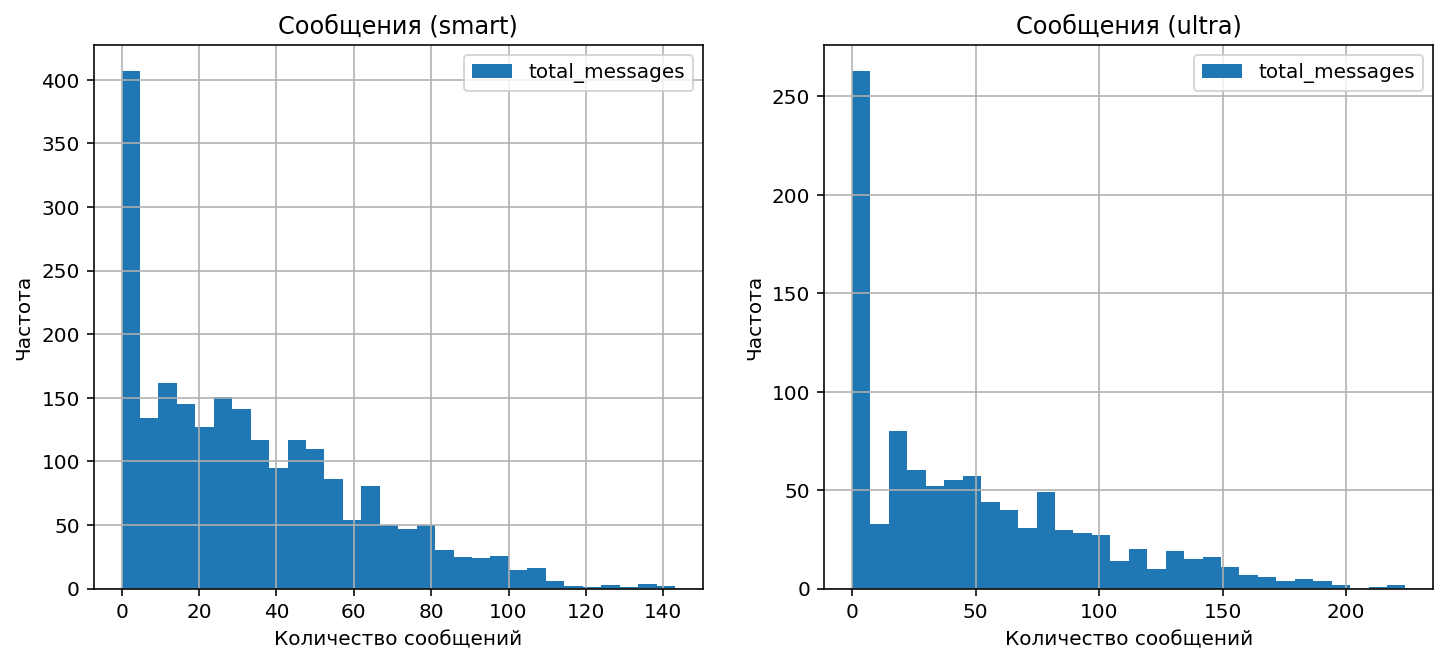

In [44]:
figure, ax = plt.subplots(1,2,figsize=(12,5))

df_smart.plot(kind='hist', y='total_messages', title='Cообщения (smart)', bins=30, grid=True, ax=ax[0])
ax[0].set_xlabel('Количество сообщений')
ax[0].set_ylabel('Частота')

df_ultra.plot(kind='hist', y='total_messages', title='Cообщения (ultra)', bins=30, grid=True, ax=ax[1])
ax[1].set_xlabel('Количество сообщений')
ax[1].set_ylabel('Частота')                

plt.show()

На обоих графиках сильно выделяется пик в значении 0, поэтому можно сказать, что многие пользователи не пользуются сообщениями. 
При этом клиенты с тарифом ultra активнее используют сообщения, их количество достигает 200, выше только единичные случаи, а у пользователей тарифа smart значение редко превышает больше 110 сообщений.

Обе гистограммы имеют распределение Пуассона.

Создадим сводную таблицу, рассчитав среднее значение, дисперсию и стандартное отклонение для тарифов  smart и ultra. Так как среднее значение неустойчиво к выбросам, то будем рассматривать медиану. Напишем функцию, так как такие расчёты также понадобятся для звонков и интернет-трафика:

In [45]:
def pivot_std(column):
    data = df.groupby('tariff')[column].agg(['count', 'median',
                                                                 lambda x: round(np.var(x, ddof=1)),
                                                                 lambda x: round(np.sqrt(np.var(x, ddof=1)))])
    data.columns = ['count', 'median', 'variance', 'standard_deviation']
    return data

Выведем сводную таблицу:

In [46]:
pivot_std('total_messages')

,count,median,variance,standard_deviation
tariff,,,,
smart,2229,28.0,797,28
ultra,985,38.0,2285,48


В среднем пользователи smart тратят 28 сообщений за месяц, а клиенты ultra 38 сообщений. Стандартное отклонение для smart равно 28, для ultra разброс больше, значения в выборке отличаются от среднего на 48 сообщений.

**Звонки**

Построим графики с информацией о продолжительности звонков пользователей:

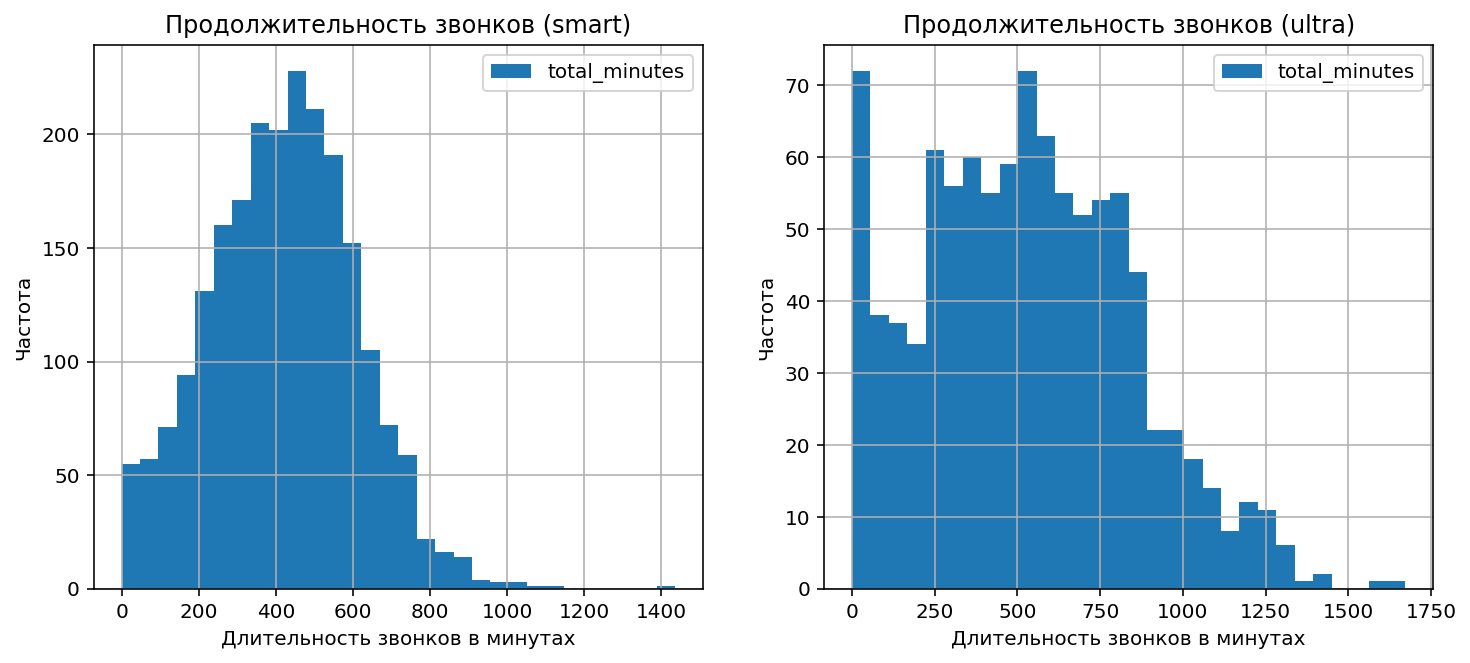

In [47]:
figure, ax = plt.subplots(1,2,figsize=(12,5))

df_smart.plot(kind='hist', y='total_minutes', title='Продолжительность звонков (smart)', bins=30, grid=True, ax=ax[0])
ax[0].set_xlabel('Длительность звонков в минутах')
ax[0].set_ylabel('Частота')

df_ultra.plot(kind='hist', y='total_minutes', title='Продолжительность звонков (ultra)', bins=30, grid=True, ax=ax[1])
ax[1].set_xlabel('Длительность звонков в минутах')
ax[1].set_ylabel('Частота')                

plt.show()

У большинства пользователей smart на разговоры в месяц уходит от 200 до 600 минут, у пользователей тарифа ultra звонки более длительные и составляют от 250 и примерно до 850 минут, хотя многие клиенты совсем не используют минуты разговора. Выбросами по тарифу smart являются значения более 1000 минут, а для ultra звонки продолжительностью более 1400 минут.

Гистограмма с тарифом smart имеет вид нормального распределения, а график с тарифом ultra похож на распределение Пуассона.

Вызовем функцию pivot_std для вывода сводной таблицы с расчетами по звонкам:

In [48]:
pivot_std('total_minutes')

,count,median,variance,standard_deviation
tariff,,,,
smart,2229,422.0,36219,190
ultra,985,518.0,100874,318


В среднем клиенты smart разговаривают 422 минуты, у пользователей ultra время разговора составляет 518 минут. По количеству израсходованных минут разброс довольно большой и сильно отклоняется от среднего, особенно у пользователей тарифа ultra, стандартнее отклонение у которых 318 минут.

**Интернет-трафик**

Построим графики для оценки использования объёма интернет-трафика:

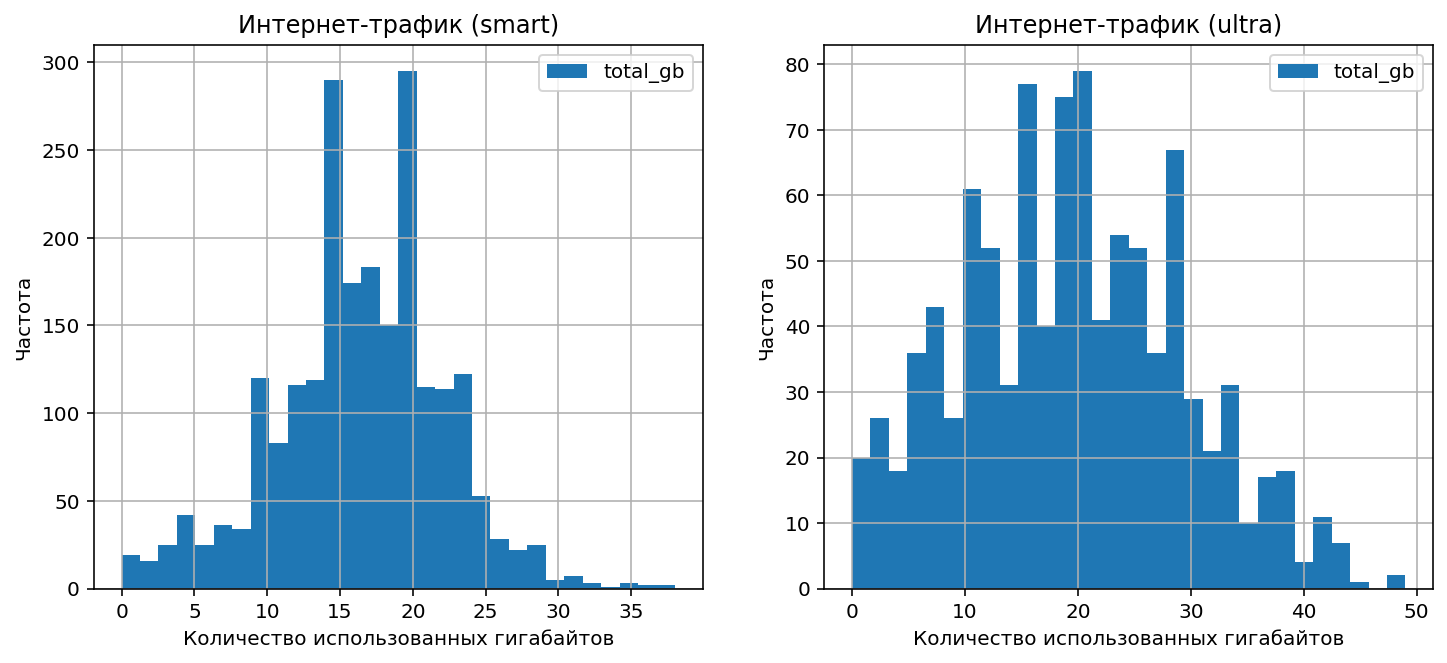

In [49]:
figure, ax = plt.subplots(1,2,figsize=(12,5))

df_smart.plot(kind='hist', y='total_gb', title='Интернет-трафик (smart)', bins=30, grid=True, ax=ax[0])
ax[0].set_xlabel('Количество использованных гигабайтов')
ax[0].set_ylabel('Частота')

df_ultra.plot(kind='hist', y='total_gb', title='Интернет-трафик (ultra)', bins=30, grid=True, ax=ax[1])
ax[1].set_xlabel('Количество использованных гигабайтов')
ax[1].set_ylabel('Частота')                

plt.show()

Большинство пользователей тарифа smart используют от 9 до 25 гигабайт, с выделяющимися значениями 15 и 20 гигабайт. В тарифе ultra эти данные похожи, в основном тратится от 10 до 29 гигабайт, с пиком 15 и 20 гигабайт, но также видно, что есть клиенты, которые чаще используют больше 30 гигабайт, для тарифа smart это единичные случаи. 

Гистограммы имеют вид нормального распределения.

Обратимся к функции pivot_std и выведем сводную таблицу для интернет-трафика:

In [50]:
pivot_std('total_gb')

,count,median,variance,standard_deviation
tariff,,,,
smart,2229,17.0,33,6
ultra,985,19.0,97,10


Пользователи тарифа smart в среднем используют 17 гигабайт, а пользователи ultra - 19 гб. Для тарифа smart стандартное отклонение 6 гб, а для ultra разброс величин больше и составляет 10 гб.

**Выручка**

Построим графики для оценки распределения выручки по тарифам:

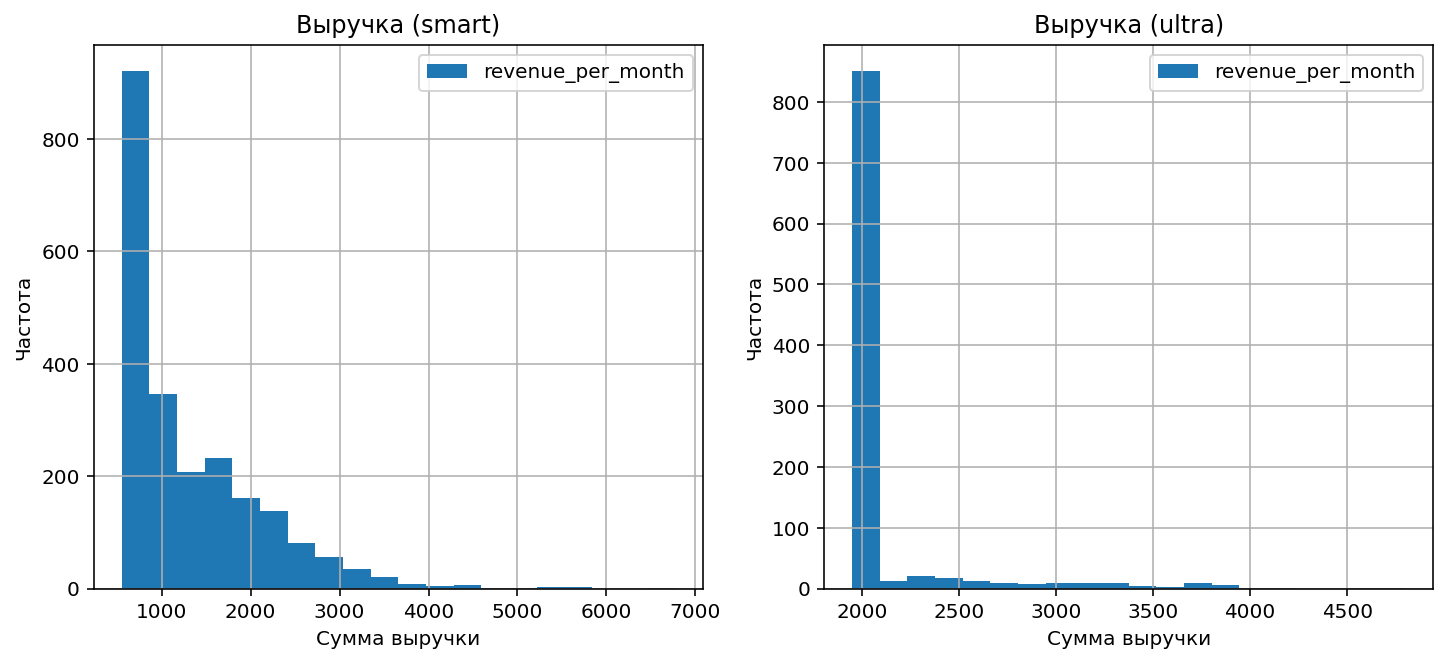

In [51]:
figure, ax = plt.subplots(1,2,figsize=(12,5))

df_smart.plot(kind='hist', y='revenue_per_month', title='Выручка (smart)', bins=20, grid=True, ax=ax[0])
ax[0].set_xlabel('Сумма выручки')
ax[0].set_ylabel('Частота')

df_ultra.plot(kind='hist', y='revenue_per_month', title='Выручка (ultra)', bins=20, grid=True, ax=ax[1])
ax[1].set_xlabel('Сумма выручки')
ax[1].set_ylabel('Частота')                

plt.show()

Большинство пользователей тарифа smart тратят 550 рублей в месяц, при этом очень много клиентов тратят выше этой суммы, и если сравнивать с пользователями тарифа ultra, чаще не укладываются в установленный лимит. Клиенты ultra редко тратят больше 1950 рублей.

Сгруппируем по тарифам и выведем числовое описание данных методом describe():

In [52]:
round(df.groupby('tariff')['revenue_per_month'].describe())

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,1290.0,818.0,550.0,550.0,1023.0,1750.0,6770.0
ultra,985.0,2070.0,376.0,1950.0,1950.0,1950.0,1950.0,4800.0


В выборке больше клиентов тарифа smart, средняя сумма выручки по этому тарифу меньше, чем по тарифу ultra.

<div style="border: solid green 2px; padding: 20px">
    
**Выводы**
    
* Пользователи тарифа «Ультра» более активные и используют больше сообщений, минут для разговоров и гигабайт интернет-трафика. При этом пользователей тарифа «Смарт» чаще используют услуги сверх тарифного пакета и выходят за пределы ежемесячной абонентской платы.
* Многие клиенты не пользуются сообщениями.
* Большинству требуется 15-20 гб интернета, это также характерно для обоих тарифов.

<a name="4"><h2>4 Проверка гипотез</h2></a>

<a name="4.1"><h3>4.1 Сравнение средней выручки по тарифам</h3></a>

Для оценки выручки сделаем срез таблицы без учёта выбивающихся значений. Выбросами будем считать сумму выше 4000 тысяч:

In [53]:
df_filter = df.query('revenue_per_month < 4000').reset_index(drop=True)

Проверим гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. 

Сформулируем нулевую и альтернативную гипотезу:

* H₀: средняя выручка тарифа «Ультра» равна выручке «Смарт».
* H₁: средняя выручка тарифа «Ультра» различается с выручкой «Смарт».

Для проверки равенства средних двух независимых совокупностей воспользуемся методом scipy.stats.ttest_ind(). Перед проверкой гипотезы посмотрим размах выборки и дисперсию:

In [54]:
tariff_group = round(df_filter.groupby('tariff')['revenue_per_month'].agg(['count', lambda x: round(np.var(x, ddof=1))]))
tariff_group.columns = ['count', 'variance']
tariff_group

,count,variance
tariff,,
smart,2211,567145
ultra,981,118978


Так как выборки разного размера и дисперсии не равны, то укажем в методе equal_var = False и проверим гипотезы:

In [55]:
revenue_smart = df_filter.query('tariff == "smart"')['revenue_per_month']
revenue_ultra = df_filter.query('tariff == "ultra"')['revenue_per_month']

alpha = .05

results = st.ttest_ind(
    revenue_smart, 
    revenue_ultra,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.4833474442437034e-297
Отвергаем нулевую гипотезу


<div style="border: solid green 2px; padding: 20px">
    
**Вывод**

Проверка гипотез показала, что вероятность того, что выручки равны очень низка и практически равна нулю, поэтому отвергли нулевую гипотезу о равенстве выручки тарифов «Ультра» и «Смарт».

<a name="4.2"><h3>4.2 Сравнение средней выручки пользователей из Москвы и регионов</h3></a>

Проверим гипотезу о равенстве средней выручки пользователей из Москвы и выручки пользователей из других регионов.

Сформулируем нулевую и альтернативную гипотезу:

* H₀: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
* H₁: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Добавим в таблицу 'df_filter' столбец 'moscow_city' типа bool. Eсли пользователь из Москвы, то столбец примет значение True, иначе False.

In [56]:
df_filter['moscow_city'] = df_filter['city'] == "Москва"

Проверим, что столбец был добавлен:

In [57]:
df_filter.head()

,user_id,month,total_messages,total_calls,total_minutes,total_gb,city,tariff,revenue_per_month,moscow_city
0,1000,5,22,22,159,3,Краснодар,ultra,1950.0,False
1,1000,6,60,43,172,23,Краснодар,ultra,1950.0,False
2,1000,7,75,47,340,14,Краснодар,ultra,1950.0,False
3,1000,8,81,52,408,14,Краснодар,ultra,1950.0,False
4,1000,9,57,58,466,15,Краснодар,ultra,1950.0,False


Посмотрим размер выборок и дисперсию:

In [58]:
city_group = df_filter.groupby('moscow_city')['revenue_per_month'].agg(['count', lambda x: round(np.var(x, ddof=1))])
city_group.columns = ['count', 'variance']
city_group

,count,variance
moscow_city,,
False,2584,575332
True,608,523553


Выборки разного размера и дисперсии не равны, поэтому также укажем equal_var = False и воспользуемся методом scipy.stats.ttest_ind():

In [59]:
revenue_moscow = df_filter.query('moscow_city == True')['revenue_per_month']
revenue_region = df_filter.query('moscow_city == False')['revenue_per_month']

alpha = .05

results = st.ttest_ind(
    revenue_moscow, 
    revenue_region,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.34033152075526585
Не получилось отвергнуть нулевую гипотезу


<div style="border: solid green 2px; padding: 20px">
    
**Вывод**
    
Проверка гипотез показала, что нельзя отвергнуть нулевую гипотезу о том, что средняя выручка по Москве равна средней выручке по регионам.

<a name="5"><h2>5 Общие выводы</h2></a>

В результате работы рассмотрели два тарифных плана оператора сотовой связи компании «Мегалайн».

Сделаны следующие выводы:
    
Пользователи тарифа ultra наиболее активные и расходуют больше сообщений, минут для разговора и гб интернет-трафика. Так, в среднем:
    
* клиенты ultra отправляют 38 сообщений, а пользователи smart на 10 сообщений меньше;
* продолжительность затраченных в месяц минут равна 518, что почти на 100 минут больше, чем у пользователей тарифа smart;
* по тарифу ultra используется 19 гб, по тарифу smart 17 гигабайт. Пользователи обоих тарифов близки по среднему значению в использовании интернет-трафика, но в тарифе ultra многие пользователи тратят больше 30 гигабайт, тогда как в тарифе smart такие пользователи встречаются очень редко.
     
Также отметили, что многие клиенты не пользуются сообщениями.
    
Проверили две гипотезы и установили, что:
* средняя выручка тарифа ultra не равна выручке smart;
* средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
    
Рассмотрев выручку по обоим тарифам, можно сказать, что несмотря на то, что пользователи smart чаще переплачивают, средняя выручка по этому тарифу 1290 рублей, а выручка клиентов ultra составляет 2070 рублей, поэтому тариф ultra более выгоден, если не учитывать затраты и ресурсы компании на предоставление услуг по тарифному пакету.